### Readme
This file cntains examples of using the Python library `xraytools` to perform some basic X-ray calculations, espeically when using it for the LCLS facility with `lcls2_fel_new`. The examples are not exhaustive, but they should give you a good starting point for using the library. The examples are organized into sections based on the type of analysis being performed.

#### `xraytools`
The `xraytools` library ([Github](https://github.com/your-repo/xraytools)) is a Python package designed for X-ray calculations. The installation instructions and dependencies are listed in the `README.md` file of the repository. The updated version will be available in the Github repository.

#### `lcls2_fel_new`
The `lcls2_fel_new` library contains FEL parameters (covering LCLS-NC, LCLS-SC, and LCLS-II-HE) and beamline information for the LCLS facility. It is used in conjunction with the `xraytools` library to perform calculations specific to the LCLS facility.The updated version will be available in this folder.

### Common heading

In [2]:
import xraytools as xt
import lcls2_fel_new as fel
import numpy as np
import matplotlib.pyplot as plt

# This is a Jupyter notebook command so that the code is reloaded automatically when it is changed.
%load_ext autoreload
%autoreload 2

# The directory of LCLS2_fel_new library will be displayed to check the right version is loaded.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simple `xraytools` calculations

In [14]:
mJ = 1
keV = 1
rms_mm = 0.5
kHz = 33.2
matID = 'Fe'  # simbol of material, the full list is in xraytools.py
eVatom = xt.eVatom(matID, keV, mJ, rms_mm)  # eV/atom on material
drillSpeed = xt.drillSpeed(matID, mJ * kHz, rms_mm*2.355)
print(f'The dose on {matID} is {eVatom:.2f} eV/atom for {mJ:.2f} mJ, {keV:.2f} keV, {rms_mm*2.355:.3f} mm FWHM beam.')
print(f'The drill speed on {matID} is {drillSpeed:.2f} mm/s for {mJ:.2f} mJ, {kHz:.2f} kHz, {rms_mm*2.355:.3f} mm FWHM beam.')

The dose on Fe is 0.34 eV/atom for 1.00 mJ, 1.00 keV, 1.177 mm FWHM beam.
The drill speed on Fe is 0.32 mm/s for 1.00 mJ, 33.20 kHz, 1.177 mm FWHM beam.


### Calculations using `lcls2_fel_new`

In [5]:
hxr = fel.HXR_HE_S2E()  # pick a source, using HE HXR S2E as an example
xpp = fel.XPP_optics()  # pick a beamline, using XPP as an example

#### FEL parameters

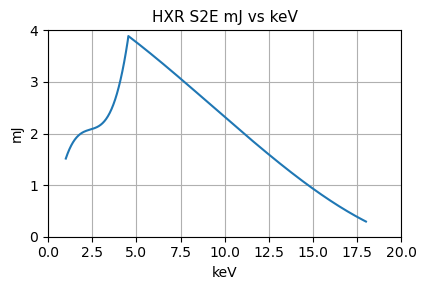

In [9]:
keVs = hxr.keVs  # keV is vectorizeed, either a single value or an array of values can be used
mJ = hxr.mJ_with_margin()  # keV is optional, default is the full energy range of the source
xt.plot(keVs, mJ, xlabel='keV', ylabel='mJ', title='HXR S2E mJ vs keV', xmin=0, xmax=20, ymax = 4)  # a simple plot function in xraytools

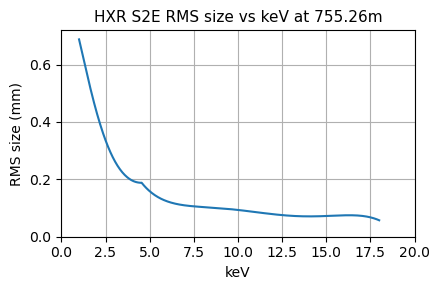

In [11]:
keVs = hxr.keVs  # keV is vectorizeed, either a single value or an array of values can be used
Z = xpp.ST1L0  # get the Z position of the XPP stopper in FEE, check the code to see what Z positions are available
rms = hxr.rms_mm(Z)  # return the RMS size of the beam at the Z position in mm, keV is optional, default is the full energy range of the source
xt.plot(keVs, rms, xlabel='keV', ylabel='RMS size (mm)', title=f'HXR S2E RMS size vs keV at {Z:.2f}m', xmin=0, xmax=20)

#### NC beam dose on a stopper

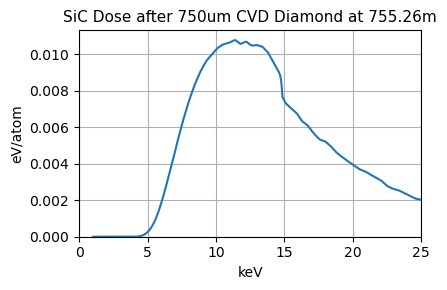

In [19]:
hxr = fel.HXR_Cu_HD()
keVs = hxr.keVs
mJ = hxr.mJ()

xpp = fel.XPP_optics()
Z = xpp.ST1L0
rms = hxr.rms_mm(Z)

refl = xpp.refl_2mirrors(keVs)  # reflectivity of two XPP mirrors. General reflectivity calculation is in "Reflectivity_coated" and "Reflectivity_uncoated" functions in xraytools.py
trans = xt.transmission('CVD', 750e-6, keVs, density=3.515)  # transmission of 750 um thick CVD diamond, set density as 3.515 g/cm^3

eVatom = xt.eVatom('SiC', keVs, mJ * refl * trans, rms)
xt.plot(keVs, eVatom, xlabel='keV', ylabel='eV/atom', title=f'SiC Dose after 750um CVD Diamond at {Z:.2f}m', xmin=0, xmax=25)

### Diffraction beam calculations

#### Beam size along the beamline

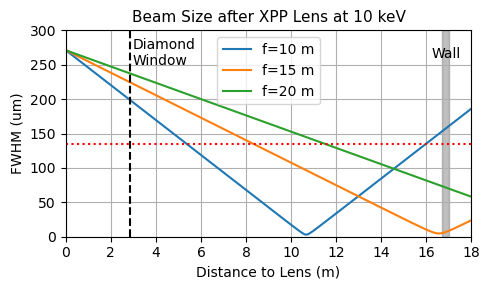

In [15]:
lensZ = xpp.LensZ
windowZ = xpp.Diamond_Window
wall_us = xpp.H1_3_ds
wall_ds = wall_us + 0.3048

dZ = np.linspace(0, 20, 2000)  # distance to lens, cover 0 to more than the wall
keV = 10
focal_length = [10, 15, 20]
srcZ = hxr._srcZ_m_R1(keV)
sigma0 = hxr._sigma_um_R1(keV)
M2 = hxr.M_squared(keV)  # currently only HE S2E sources have M2 value, other sources should use 1.0

q0 = xt.initGaussianBeam(keV, sigma0, M2)
q1 = xt.propagateFreeSpace(q0, lensZ - srcZ)  # from source to lens

plt.figure(figsize=(5,3), dpi=100, facecolor='w', edgecolor='k')
for f in focal_length:
    q2 = xt.propagateThinLens(q1, f)  # after lens
    q3 = xt.propagateFreeSpace(q2, dZ)  # from lens to wall
    q3_rms = xt.getGaussianSigma_um(q3, keV, M2)
    plt.plot(dZ, q3_rms*2.355, label=f'f={f} m')
plt.axvline(x=windowZ - lensZ, color='k', linestyle='--')
plt.axvspan(wall_us-lensZ, wall_ds-lensZ, color='gray', alpha=0.5)
plt.axhline(y=q3_rms[0]*2.355/2, color='r', linestyle=':')
plt.text(x=windowZ-lensZ+0.1, y=250, s='Diamond\nWindow')
plt.text(x=wall_us-lensZ-0.5, y=260, s='Wall')
plt.xlabel('Distance to Lens (m)')
plt.ylabel('FWHM (um)')
plt.title(f'Beam Size after XPP Lens at {keV} keV', fontsize=11)
plt.legend()
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 300)
plt.tight_layout()
plt.show()